In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio

In [3]:
dataset_path = Path(r"C:\Users\AmbatiChaitanya\Documents\weed detection data\dataset")
images = list(dataset_path.glob(r'**/*.tif'))
labels = [x.parents[0].stem for x in images]

In [4]:
images = pd.Series(images, name="Images").astype(str)
labels = pd.Series(labels, name="Labels").astype(str)

data = pd.concat([images, labels], axis=1)
data = data.sample(frac = 1, random_state=42).reset_index(drop = True)
data.head()

,Images,Labels
0,C:\Users\AmbatiChaitanya\Documents\weed detect...,soybean
1,C:\Users\AmbatiChaitanya\Documents\weed detect...,soil
2,C:\Users\AmbatiChaitanya\Documents\weed detect...,grass
3,C:\Users\AmbatiChaitanya\Documents\weed detect...,soil
4,C:\Users\AmbatiChaitanya\Documents\weed detect...,grass


C:\Users\AmbatiChaitanya\AppData\Local\Temp\ipykernel_4340\1357142339.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ax.imshow(imageio.imread(data.Images[i]))


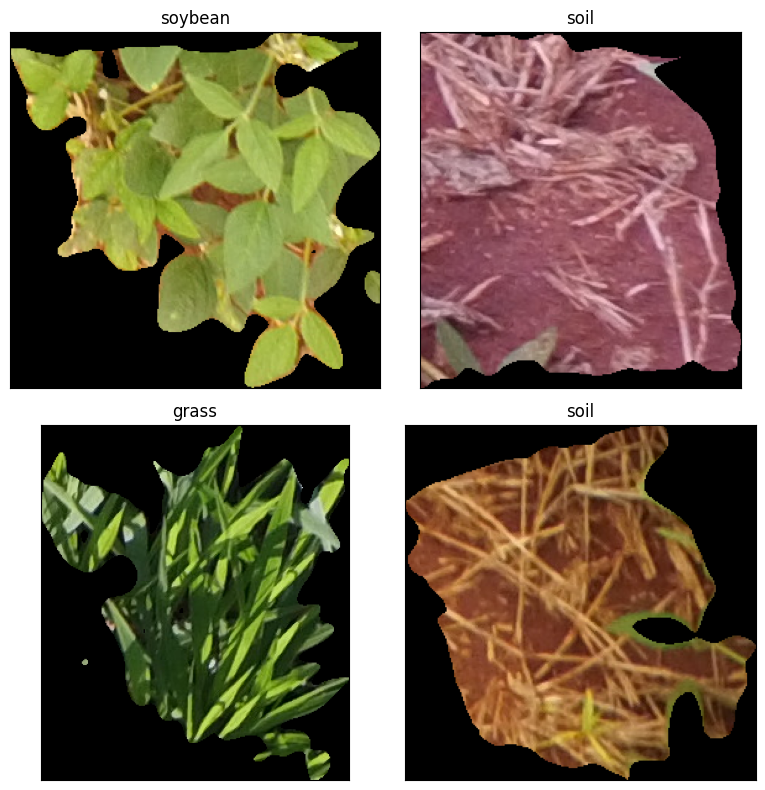

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(imageio.imread(data.Images[i]))
    ax.set_title(data.Labels[i], )
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import efficientnet

train_generator_eff_net = ImageDataGenerator(
    preprocessing_function = efficientnet.preprocess_input,
    validation_split = 0.1
)

test_generator_eff_net = ImageDataGenerator(
    preprocessing_function = efficientnet.preprocess_input
)

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data, train_size=0.9, shuffle=True, random_state=42, stratify=data[["Labels"]])

train = train_generator_eff_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    sheer_range=0.2,
    brightness_range=[0.5,1.5],
    horizontal_flip=True,
    fill_mode="nearest"
)

validation = train_generator_eff_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5,1.5],
    sheer_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test = test_generator_eff_net.flow_from_dataframe(
    dataframe=test_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shuffle=False
)

Found 12422 validated image filenames belonging to 4 classes.
Found 1380 validated image filenames belonging to 4 classes.
Found 1534 validated image filenames belonging to 4 classes.


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import efficientnet
from sklearn.model_selection import train_test_split
local_h5_file_path = r'C:\Users\AmbatiChaitanya\Documents\weed detection data\efficientnetb0_notop.h5'
basemodel = efficientnet.EfficientNetB0(
    include_top=False,
    weights=local_h5_file_path,  
    input_shape=(224, 224, 3),
    pooling='avg'
)
basemodel.trainable = False

In [11]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# building the Predictor layers
x = Dense(256, activation='relu')(basemodel.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)

outputs = Dense(4, activation='softmax')(x)

efficientnet = Model(inputs=basemodel.inputs, outputs=outputs)

In [12]:
efficientnet.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


CHECKPOINTS_DIR = r"C:\Users\AmbatiChaitanya\Documents\weed detection data"


checkpoint_filepath = CHECKPOINTS_DIR + "\\efficientnet_checkpoint.keras"


Path(CHECKPOINTS_DIR).mkdir(exist_ok=True)


results = efficientnet.fit(
    train,
    validation_data=validation,
    batch_size=32,
    epochs=10,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True
        ), 
        ReduceLROnPlateau(patience=2),
        ModelCheckpoint(
            filepath=checkpoint_filepath,  
            monitor="val_loss",
            save_best_only=True
        ),
    ]
)


Epoch 1/10


c:\Users\AmbatiChaitanya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


389/389 ━━━━━━━━━━━━━━━━━━━━ 163s 397ms/step - categorical_accuracy: 0.9206 - loss: 0.2241 - val_categorical_accuracy: 0.9841 - val_loss: 0.0407 - learning_rate: 0.0010
Epoch 2/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 154s 395ms/step - categorical_accuracy: 0.9837 - loss: 0.0464 - val_categorical_accuracy: 0.9819 - val_loss: 0.0516 - learning_rate: 0.0010
Epoch 3/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 148s 380ms/step - categorical_accuracy: 0.9871 - loss: 0.0401 - val_categorical_accuracy: 0.9891 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 4/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 147s 377ms/step - categorical_accuracy: 0.9909 - loss: 0.0299 - val_categorical_accuracy: 0.9855 - val_loss: 0.0394 - learning_rate: 0.0010
Epoch 5/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 149s 382ms/step - categorical_accuracy: 0.9895 - loss: 0.0288 - val_categorical_accuracy: 0.9841 - val_loss: 0.0528 - learning_rate: 0.0010
Epoch 6/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 161s 412ms/step - categorical_accuracy: 0.9962 - loss: 0.0133 - val_cat

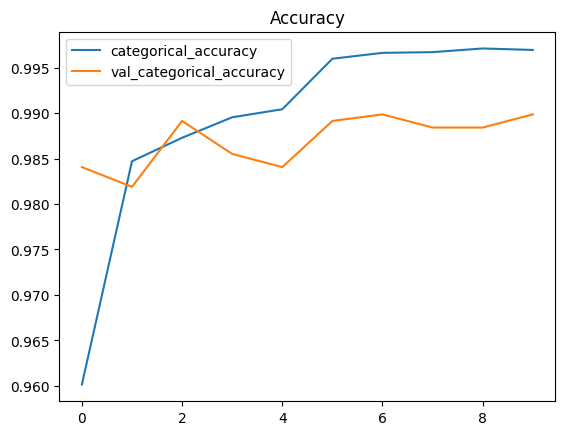

In [20]:
pd.DataFrame(results.history)[['categorical_accuracy', 'val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()

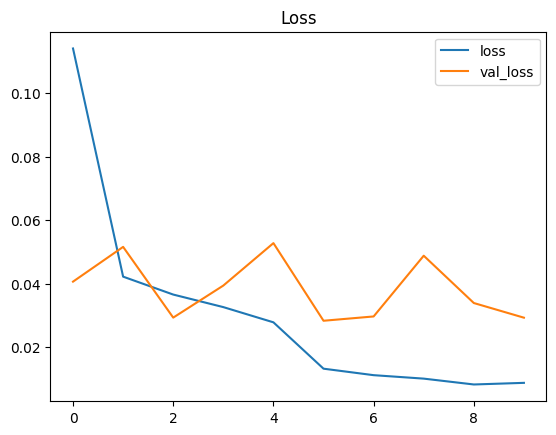

In [21]:
pd.DataFrame(results.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

In [29]:
from tensorflow.keras.models import save_model
MODEL_PATH = Path(r"C:\Users\AmbatiChaitanya\Documents\weed detection data")
MODEL_PATH.mkdir(exist_ok=True)
model_file_path = MODEL_PATH / "efficientnet_model.keras"
efficientnet.save(str(model_file_path))

In [30]:
np.save('model_history.npy', results.history)

In [31]:
results = efficientnet.evaluate(test)

c:\Users\AmbatiChaitanya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 322ms/step - categorical_accuracy: 0.9918 - loss: 0.0174


In [32]:
predictions = np.argmax(efficientnet.predict(test), axis=1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 385ms/step


In [33]:
from sklearn.metrics import classification_report
labels = dict((v, k) for k, v in train.class_indices.items())
actual = list(test_df.Labels)
predictions = [labels[i] for i in predictions]
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

   broadleaf       0.97      0.99      0.98       119
       grass       0.99      1.00      1.00       352
        soil       1.00      1.00      1.00       325
     soybean       1.00      0.99      0.99       738

    accuracy                           0.99      1534
   macro avg       0.99      0.99      0.99      1534
weighted avg       0.99      0.99      0.99      1534



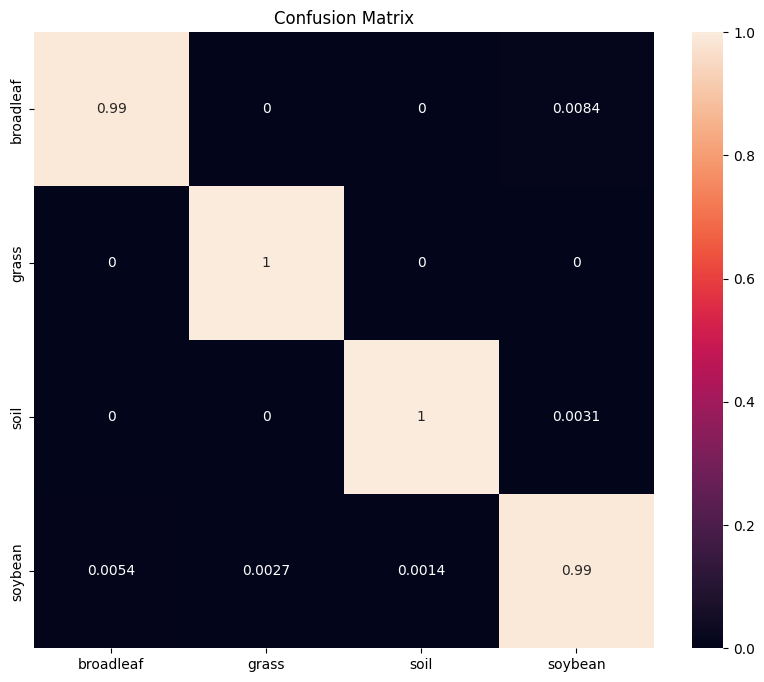

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf = confusion_matrix(actual, predictions, normalize = "true")
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, xticklabels = sorted(set(actual)), yticklabels = sorted(set(actual)))
plt.title('Confusion Matrix')
plt.show()